## ELEC4840 Assignment 1

Name: Young, James Yang

Student ID: 20740589

- Problem 1 (40%)

- Problem 2 (60%)

In [1]:
# import packages
import torch
from torch import nn
from torchvision import datasets, transforms
from tqdm import tqdm

/home/jamesyoung/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## HINT
You should run training on __training dataset__, validate the model's performance during training using __validation dataset__. After finishing training, select the model that has the best performance on validation dataset, then report the model's performance based on the data of the __test dataset__.

In [2]:
# load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=0.5,
        std=0.5
    )
])

data_train = datasets.MNIST(
    root="./data/",
    transform=transform,
    train=True,
    download=True
)

data_test = datasets.MNIST(
    root="./data/",
    transform=transform,
    train=False
)

split_train_size = int(0.8*(len(data_train)))  # from test data, split 50% as validation set
split_valid_size = len(data_train) - split_train_size  # split 50% as test set

train_set, valid_set = torch.utils.data.random_split(
    data_train, [split_train_size, split_valid_size])

loader_train = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=64,
    shuffle=True
)

loader_valid = torch.utils.data.DataLoader(
    dataset=valid_set,
    batch_size=64,
    shuffle=False
)

loader_test = torch.utils.data.DataLoader(
    dataset=data_test,
    batch_size=64,
    shuffle=False
)

### Problem 1. Train an MLP network on the MNIST dataset (40%)

Use a four-layer MLP to train the MNIST dataset.

| Layer |  Type  |       Input       |      Output       | Activation |
| :---: | :----: | :---------------: | :---------------: | :--------: |
|   1   | Linear |      28 * 28      |         128         |    ReLU    |
|   2   | Linear |         128         |        64         |    ReLU    |
|  3  | Dropout | 64 | 64 | - |
|   4   | Linear |        64         |        32         |    ReLU    |
|  5   | Dropout | 32 | 32 | - |
|   6   | Linear |       32         |        10         |     -      |


a.) Implement the function `__init__` and `forward` in the class `Model` (15%);

b.) Implement the training code (15%).

c.) Plot the curve of accuracy and loss(10%). Compare and discuss the results' difference between the model with / without dropout operation(5%).

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        ## ----- write your code here
        # layer 1: 28*28 input, 128 output
        self.fc1 = nn.Linear(28 * 28, 128)
        # layer 2: 128 input, 64 output
        self.fc2 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(0.3)
        # layer 3: 64 input, 32 output
        self.fc3 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        # layer 4: 32 input, 10 output
        self.fc4 = nn.Linear(32, 10)
        
        

    def forward(self, x):
        ## ----- write your code here
        ## Remember to return the output and delete the 'pass' command below
        x = torch.flatten(x, start_dim=1, end_dim=3)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout1(x)
        x = nn.functional.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

In [4]:
# reference used: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

In [5]:
max_epoch = 10
use_cuda = True

# model initialization
model = Model()
if use_cuda:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss() # -- write your code here --

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)# -- write your code here --

loss_list = []
acc_train_list = []
acc_valid_list = []

best_valid_loss = float('inf')

for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0
    valid_loss = 0.0
    valid_correct = 0
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    # training
    # call a function to control the dropout behaviour 
    # your code here
    model.train(True)

    for data in tqdm(loader_train):
        # set all gradients to zero
        optimizer.zero_grad()

        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        # model forward
        outputs = model(images) # -- write your code here --

        # calculate loss
        loss = criterion(outputs, labels) # -- write your code here --

        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(pred == labels)

    # record loss, accuracy
    loss = running_loss / len(train_set)
    loss_list.append(loss)
    acc_train = running_correct / len(train_set)
    acc_train_list.append(acc_train.item())

    # testing

    # call a function to control the dropout behaviour 
    model.eval()

    valid_correct = 0
    for data in loader_valid:
        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        # model forward
        voutputs = model(images)# -- write your code here --
        
        # calculate loss
        vloss = criterion(voutputs, labels)
        vpred = torch.argmax(voutputs, dim=1)
        valid_loss += vloss.item()
        valid_correct += torch.sum(vpred == labels)
    

    # Save best checkpoint
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_checkpoint_mnist.pt')

    acc_valid = valid_correct / len(valid_set)
    acc_valid_list.append(acc_valid.item())
    print("Loss {:.4f}, Train Accuracy {:.4f}%, Validation Accuracy {:.4f}%".format(
        loss,
        acc_train * 100,
        acc_valid * 100
    ))


model.load_state_dict(torch.load('best_checkpoint_mnist.pt'))

# call a function to control the dropout behaviour 
model.eval()

test_loss = 0.0
correct = 0
total = 0
total = len(data_test)

with torch.no_grad():
    for images, labels in loader_test:
        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        # model forward
        outputs = model(images)
        
        # calculate accuracy on test set
        pred = torch.argmax(outputs, dim=1)
        tloss = criterion(outputs, labels)
        test_loss += tloss.item()
        correct += torch.sum(pred == labels)

        
        
        
        
acc_test=correct/total
print("Best model on test set: Test Accuracy {:.4f}%".format(
        acc_test * 100
    ))

 -- Epoch 1/10


100%|██████████| 750/750 [00:06<00:00, 107.49it/s]


Loss 0.0131, Train Accuracy 72.6979%, Validation Accuracy 90.0083%
 -- Epoch 2/10


100%|██████████| 750/750 [00:06<00:00, 112.41it/s]


Loss 0.0054, Train Accuracy 90.3771%, Validation Accuracy 93.4917%
 -- Epoch 3/10


100%|██████████| 750/750 [00:06<00:00, 112.81it/s]


Loss 0.0040, Train Accuracy 93.0708%, Validation Accuracy 94.7083%
 -- Epoch 4/10


100%|██████████| 750/750 [00:06<00:00, 115.69it/s]


Loss 0.0034, Train Accuracy 94.0104%, Validation Accuracy 94.9583%
 -- Epoch 5/10


100%|██████████| 750/750 [00:06<00:00, 114.75it/s]


Loss 0.0030, Train Accuracy 94.7750%, Validation Accuracy 95.0667%
 -- Epoch 6/10


100%|██████████| 750/750 [00:06<00:00, 116.32it/s]


Loss 0.0028, Train Accuracy 95.2500%, Validation Accuracy 96.0250%
 -- Epoch 7/10


100%|██████████| 750/750 [00:06<00:00, 114.79it/s]


Loss 0.0024, Train Accuracy 95.8104%, Validation Accuracy 95.9000%
 -- Epoch 8/10


100%|██████████| 750/750 [00:06<00:00, 117.61it/s]


Loss 0.0023, Train Accuracy 96.0229%, Validation Accuracy 96.2083%
 -- Epoch 9/10


100%|██████████| 750/750 [00:06<00:00, 118.55it/s]


Loss 0.0021, Train Accuracy 96.4625%, Validation Accuracy 95.8167%
 -- Epoch 10/10


100%|██████████| 750/750 [00:06<00:00, 117.14it/s]


Loss 0.0020, Train Accuracy 96.3750%, Validation Accuracy 95.9917%
Best model on test set: Test Accuracy 48.6700%


c.) Plot loss and accuracy curve

In the previous cell, you have recorded the loss and train/test accuracy in `loss_list`, `acc_train_list`, and `acc_test_list`, respectively. In this problem, you are required to plot two figures: 1.) training loss curve (5%); 2.) training and testing accuracy curves in the same figure (5%).

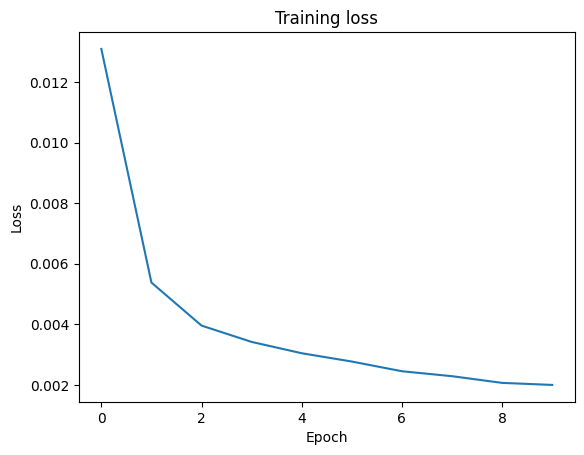

In [6]:
import numpy as np
from matplotlib import pyplot as plt

## ----- write your code here

# training loss curve
plt.figure()
plt.plot(loss_list)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

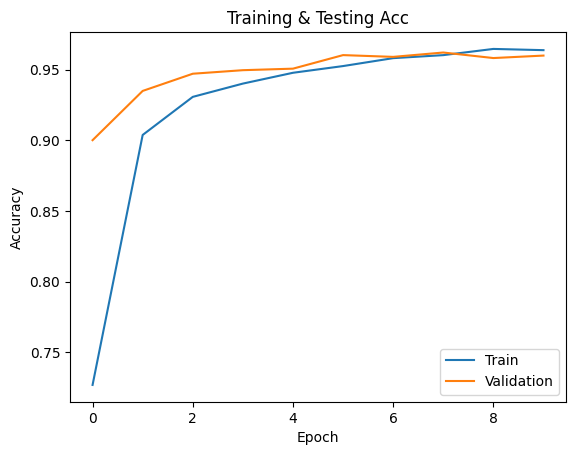

In [7]:
# training and testing accuracy curves
plt.figure()
plt.title("Training & Testing Acc")
plt.plot(acc_train_list, label="Train")
plt.plot(acc_valid_list, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Compare with no dropout

In [8]:
!rm best_checkpoint_mnist.pt

In [9]:
class Model_NoDropout(nn.Module):
    def __init__(self):
        super(Model_NoDropout, self).__init__()
        ## ----- write your code here
        # layer 1: 28*28 input, 128 output
        self.fc1 = nn.Linear(28 * 28, 128)
        # layer 2: 128 input, 64 output
        self.fc2 = nn.Linear(128, 64)
        # self.dropout1 = nn.Dropout(0.2)
        # layer 3: 64 input, 32 output
        self.fc3 = nn.Linear(64, 32)
        # self.dropout2 = nn.Dropout(0.2)
        # layer 4: 32 input, 10 output
        self.fc4 = nn.Linear(32, 10)
        
        

    def forward(self, x):
        ## ----- write your code here
        ## Remember to return the output and delete the 'pass' command below
        x = torch.flatten(x, start_dim=1, end_dim=3)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        # x = self.dropout1(x)
        x = nn.functional.relu(self.fc3(x))
        # x = self.dropout2(x)
        x = self.fc4(x)
        return x

In [10]:
max_epoch = 10
use_cuda = True

# model initialization
model = Model_NoDropout()
if use_cuda:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss() # -- write your code here --

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)# -- write your code here --

loss_list = []
acc_train_list = []
acc_valid_list = []

best_valid_loss = float('inf')

for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0
    valid_loss = 0.0
    valid_correct = 0
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    # training
    # call a function to control the dropout behaviour 
    # your code here
    model.train(True)

    for data in tqdm(loader_train):
        # set all gradients to zero
        optimizer.zero_grad()

        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        # model forward
        outputs = model(images) # -- write your code here --

        # calculate loss
        loss = criterion(outputs, labels) # -- write your code here --

        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(pred == labels)

    # record loss, accuracy
    loss = running_loss / len(train_set)
    loss_list.append(loss)
    acc_train = running_correct / len(train_set)
    acc_train_list.append(acc_train.item())

    # testing

    # call a function to control the dropout behaviour 
    model.eval()

    valid_correct = 0
    for data in loader_valid:
        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        # model forward
        voutputs = model(images)# -- write your code here --
        
        # calculate loss
        vloss = criterion(voutputs, labels)
        vpred = torch.argmax(voutputs, dim=1)
        valid_loss += vloss.item()
        valid_correct += torch.sum(vpred == labels)
    

    # Save best checkpoint
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_checkpoint_mnist.pt')

    acc_valid = valid_correct / len(valid_set)
    acc_valid_list.append(acc_valid.item())
    print("Loss {:.4f}, Train Accuracy {:.4f}%, Validation Accuracy {:.4f}%".format(
        loss,
        acc_train * 100,
        acc_valid * 100
    ))


model.load_state_dict(torch.load('best_checkpoint_mnist.pt'))

# call a function to control the dropout behaviour 
model.eval()

test_loss = 0.0
correct = 0
total = 0
total = len(data_test)

with torch.no_grad():
    for images, labels in loader_test:
        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        # model fimport torch.nn.functional as Forward
        outputs = model(images)
        
        # calculate accuracy on test set
        pred = torch.argmax(outputs, dim=1)
        tloss = criterion(outputs, labels)
        test_loss += tloss.item()
        correct += torch.sum(pred == labels)

        
        
        
        
acc_test=correct/total
print("Best model on test set: Test Accuracy {:.4f}%".format(
        acc_test * 100
    ))

 -- Epoch 1/10


100%|██████████| 750/750 [00:06<00:00, 117.66it/s]


Loss 0.0094, Train Accuracy 80.5500%, Validation Accuracy 91.0083%
 -- Epoch 2/10


100%|██████████| 750/750 [00:06<00:00, 119.02it/s]


Loss 0.0032, Train Accuracy 93.6271%, Validation Accuracy 94.2667%
 -- Epoch 3/10


100%|██████████| 750/750 [00:06<00:00, 121.53it/s]


Loss 0.0023, Train Accuracy 95.4604%, Validation Accuracy 95.6750%
 -- Epoch 4/10


100%|██████████| 750/750 [00:06<00:00, 117.18it/s]


Loss 0.0019, Train Accuracy 96.2646%, Validation Accuracy 96.0667%
 -- Epoch 5/10


100%|██████████| 750/750 [00:06<00:00, 117.09it/s]


Loss 0.0016, Train Accuracy 96.8667%, Validation Accuracy 94.8917%
 -- Epoch 6/10


100%|██████████| 750/750 [00:06<00:00, 121.44it/s]


Loss 0.0014, Train Accuracy 97.1625%, Validation Accuracy 96.5667%
 -- Epoch 7/10


100%|██████████| 750/750 [00:06<00:00, 119.11it/s]


Loss 0.0012, Train Accuracy 97.5958%, Validation Accuracy 96.3250%
 -- Epoch 8/10


100%|██████████| 750/750 [00:05<00:00, 125.90it/s]


Loss 0.0010, Train Accuracy 97.8229%, Validation Accuracy 96.5500%
 -- Epoch 9/10


100%|██████████| 750/750 [00:06<00:00, 116.77it/s]


Loss 0.0009, Train Accuracy 98.0771%, Validation Accuracy 97.2583%
 -- Epoch 10/10


100%|██████████| 750/750 [00:06<00:00, 121.48it/s]


Loss 0.0008, Train Accuracy 98.2729%, Validation Accuracy 97.2000%
Best model on test set: Test Accuracy 48.6700%


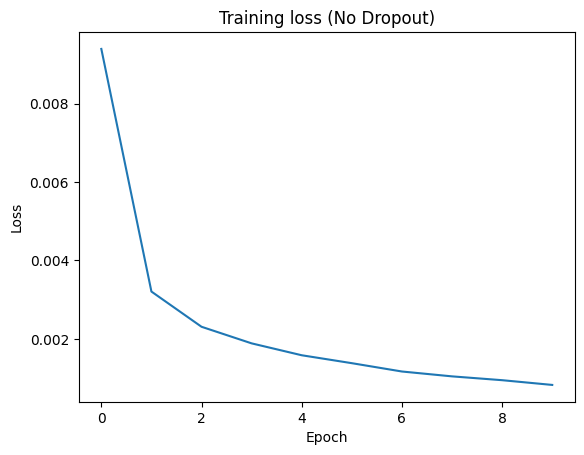

In [11]:
import numpy as np
from matplotlib import pyplot as plt

## ----- write your code here

# training loss curve
plt.figure()
plt.plot(loss_list)
plt.title("Training loss (No Dropout)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

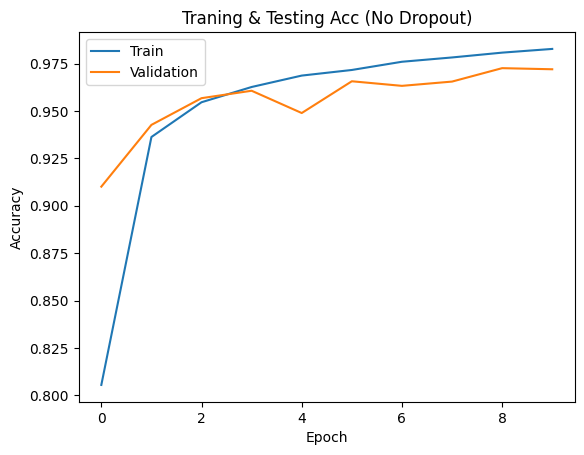

In [12]:
# training and testing accuracy curves
plt.figure()
plt.title("Traning & Testing Acc (No Dropout)")
plt.plot(acc_train_list, label="Train")
plt.plot(acc_valid_list, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Problem 2. Train a LeNet network on the EMINIST dataset (60%)

1. Implement the model and training code as instructed in the Jupyter notebook (30%);

2. In the summary report, plot the loss and accuracy curve (10%);

3. Try different choices of batch sizes, learning rates, or optimizers in your experiments. In the summary report, report the accuracy of your three choices. You may discuss the findings, the explaination, and possible solutions in a short paragraph followed by your results (30%).

load data

In [13]:
# load EMNIST dataset
train_set = datasets.EMNIST(
    root="data",
    split="balanced",
    download="True",
    train=True,
    transform=transform
)


test_set = datasets.EMNIST(
    root="data",
    split="balanced",
    download="True",
    train=False,
    transform=transform

)
entire_trainset = torch.utils.data.DataLoader(train_set, shuffle=True)

split_train_size = int(0.8*(len(entire_trainset)))  # use 80% as train set
split_valid_size = len(entire_trainset) - split_train_size  # use 20% as validation set

train_set, val_set = torch.utils.data.random_split(
    train_set, [split_train_size, split_valid_size])

print(f'train set size: {split_train_size}, validation set size: {split_valid_size}')
# EMNIST loader
loader_train_emnist = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=256, # Can be modified
    shuffle=True
)

loader_val_emnist = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=256, # Can be modified
    shuffle=True
)

loader_test_emnist = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=256, # Can be modified
    shuffle=True
)

100%|██████████| 561753746/561753746 [01:43<00:00, 5413605.09it/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw
train set size: 90240, validation set size: 22560


Implement Model

In [14]:
## ----- write your code here.
import torch.nn.functional as F

# reference: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#define-the-network
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # reshape the input tensor x before passing it through the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Train and try different hyperparameters (batch sizes, learning rate, and optimizer).

In [15]:
!rm best_checkpoint_mnist.pt

In [16]:
max_epoch = 10
use_cuda = False


# hyper-parameters to test
lr_list = [1e-1, 1e-2, 1e-3, 1e-7]
optim_list = ["SGD", "Adagrad"]
batch_list = [64, 128]



# init variables to store best hyper-parameters
best_acc = 0.0
best_lr = 0.0
best_optim = ""
best_batchsize = 0

# store all runs
loss_hist = {}
acc_training_hist = {}
acc_validation_hist = {}
acc_test_hist = {}





for lr in lr_list:
    for optim in optim_list:
        for batch in batch_list:
            # create new instance of model
            model = LeNet(47)
            if use_cuda:
                model = model.cuda()
                
            # loss function
            criterion = nn.CrossEntropyLoss() # -- write your code here --
            
            print(f"lr: {lr}, optim: {optim}, batch: {batch}")
            
            # change optimizer
            if optim == "SGD":
                optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            else:
                optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
            
            # change batch size
            loader_train_emnist = torch.utils.data.DataLoader(
                dataset=train_set,
                batch_size=batch, # Can be modified
                shuffle=True
            )

            loader_val_emnist = torch.utils.data.DataLoader(
                dataset=val_set,
                batch_size=batch, # Can be modified
                shuffle=True
            )

            loader_test_emnist = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch, # Can be modified
                shuffle=True
            )
            
            loss_list = []
            acc_train_list = []
            acc_valid_list = []

            best_valid_loss = float('inf')

            for epoch in range(max_epoch):
                running_loss = 0.0
                running_correct = 0
                valid_loss = 0.0
                valid_correct = 0
                print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

                # training
                # call a function to control the dropout behaviour 
                # your code here
                model.train(True)

                for data in tqdm(loader_train_emnist):
                    # set all gradients to zero
                    optimizer.zero_grad()

                    # fetch data
                    images, labels = data
                    if use_cuda:
                        images = images.cuda()
                        labels = labels.cuda()

                    # model forward
                    outputs = model(images) # -- write your code here --

                    # calculate loss
                    loss = criterion(outputs, labels) # -- write your code here --

                    loss.backward()
                    optimizer.step()

                    pred = torch.argmax(outputs, dim=1)
                    running_loss += loss.item()
                    running_correct += torch.sum(pred == labels)

                # record loss, accuracy
                loss = running_loss / len(loader_train_emnist.dataset)
                loss_list.append(loss)
                acc_train = running_correct / len(loader_train_emnist.dataset)
                acc_train_list.append(acc_train.item())

                # testing

                # call a function to control the dropout behaviour 
                model.eval()

                valid_correct = 0
                for data in loader_val_emnist:
                    # fetch data
                    images, labels = data
                    if use_cuda:
                        images = images.cuda()
                        labels = labels.cuda()
                    
                    # model forward
                    voutputs = model(images)# -- write your code here --
                    
                    # calculate loss
                    vloss = criterion(voutputs, labels)
                    vpred = torch.argmax(voutputs, dim=1)
                    valid_loss += vloss.item()
                    valid_correct += torch.sum(vpred == labels)
                

                # Save best checkpoint
                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), 'best_checkpoint_mnist.pt')

                acc_valid = valid_correct / len(loader_val_emnist.dataset)
                acc_valid_list.append(acc_valid.item())
                print("Loss {:.4f}, Train Accuracy {:.4f}%, Validation Accuracy {:.4f}%".format(
                    loss,
                    acc_train * 100,
                    acc_valid * 100
                ))


            model.load_state_dict(torch.load('best_checkpoint_mnist.pt'))

            # call a function to control the dropout behaviour 
            model.eval()

            test_loss = 0.0
            correct = 0
            total = 0
            total = len(loader_test_emnist.dataset)

            with torch.no_grad():
                for images, labels in loader_test_emnist:
                    # fetch data
                    images, labels = data
                    if use_cuda:
                        images = images.cuda()
                        labels = labels.cuda()
                    
                    # model forward
                    outputs = model(images)
                    
                    # calculate accuracy on test set
                    pred = torch.argmax(outputs, dim=1)
                    tloss = criterion(outputs, labels)
                    test_loss += tloss.item()
                    correct += torch.sum(pred == labels)
                    
            acc_test=correct/total
            print("Best model on test set: Test Accuracy {:.4f}%".format(
                    acc_test * 100
                ))
            if acc_test > best_acc:
                best_acc = acc_test
                best_lr = lr
                best_optim = optim
                best_batchsize = batch
            
            # store items
            loss_hist[(lr, optim, batch)] = loss_list
            acc_training_hist[(lr, optim, batch)] = acc_train_list
            acc_validation_hist[(lr, optim, batch)] = acc_valid_list
            acc_test_hist[(lr, optim, batch)] = acc_test
            
print(f'Best hyper-parameters: lr: {best_lr}, optim: {best_optim}, batchsize: {best_batchsize} acc: {best_acc}')

lr: 0.1, optim: SGD, batch: 64
 -- Epoch 1/10


  0%|          | 0/1410 [00:00<?, ?it/s]

100%|██████████| 1410/1410 [00:14<00:00, 96.71it/s]


Loss 0.0209, Train Accuracy 61.2699%, Validation Accuracy 71.1037%
 -- Epoch 2/10


100%|██████████| 1410/1410 [00:14<00:00, 100.09it/s]


Loss 0.0176, Train Accuracy 68.3355%, Validation Accuracy 66.4849%
 -- Epoch 3/10


100%|██████████| 1410/1410 [00:14<00:00, 95.79it/s]


Loss 0.0190, Train Accuracy 67.7094%, Validation Accuracy 63.5683%
 -- Epoch 4/10


100%|██████████| 1410/1410 [00:14<00:00, 99.43it/s] 


Loss 0.0228, Train Accuracy 63.8132%, Validation Accuracy 59.4592%
 -- Epoch 5/10


100%|██████████| 1410/1410 [00:14<00:00, 97.07it/s]


Loss 0.0297, Train Accuracy 55.6272%, Validation Accuracy 50.1418%
 -- Epoch 6/10


100%|██████████| 1410/1410 [00:14<00:00, 97.78it/s] 


Loss 0.0456, Train Accuracy 28.7356%, Validation Accuracy 2.4158%
 -- Epoch 7/10


100%|██████████| 1410/1410 [00:14<00:00, 97.47it/s]


Loss 0.0602, Train Accuracy 2.1443%, Validation Accuracy 2.0966%
 -- Epoch 8/10


100%|██████████| 1410/1410 [00:14<00:00, 99.27it/s] 


Loss 0.0602, Train Accuracy 2.2152%, Validation Accuracy 2.0833%
 -- Epoch 9/10


100%|██████████| 1410/1410 [00:15<00:00, 91.18it/s]


Loss 0.0599, Train Accuracy 2.6031%, Validation Accuracy 2.6729%
 -- Epoch 10/10


100%|██████████| 1410/1410 [00:15<00:00, 92.47it/s]


Loss 0.0589, Train Accuracy 3.3577%, Validation Accuracy 3.2402%
Best model on test set: Test Accuracy 39.0957%
lr: 0.1, optim: SGD, batch: 128
 -- Epoch 1/10


100%|██████████| 705/705 [00:13<00:00, 52.46it/s]


Loss 0.0084, Train Accuracy 67.5166%, Validation Accuracy 78.1915%
 -- Epoch 2/10


100%|██████████| 705/705 [00:13<00:00, 52.36it/s]


Loss 0.0049, Train Accuracy 79.2487%, Validation Accuracy 81.2855%
 -- Epoch 3/10


100%|██████████| 705/705 [00:13<00:00, 53.56it/s]


Loss 0.0044, Train Accuracy 81.2988%, Validation Accuracy 82.0833%
 -- Epoch 4/10


100%|██████████| 705/705 [00:13<00:00, 52.94it/s]


Loss 0.0049, Train Accuracy 79.8692%, Validation Accuracy 80.9752%
 -- Epoch 5/10


100%|██████████| 705/705 [00:13<00:00, 53.44it/s]


Loss 0.0042, Train Accuracy 82.3227%, Validation Accuracy 82.5754%
 -- Epoch 6/10


100%|██████████| 705/705 [00:13<00:00, 53.93it/s]


Loss 0.0040, Train Accuracy 83.0696%, Validation Accuracy 80.9885%
 -- Epoch 7/10


100%|██████████| 705/705 [00:13<00:00, 53.36it/s]


Loss 0.0042, Train Accuracy 82.3726%, Validation Accuracy 81.3697%
 -- Epoch 8/10


100%|██████████| 705/705 [00:13<00:00, 51.67it/s]


Loss 0.0040, Train Accuracy 83.1383%, Validation Accuracy 78.9495%
 -- Epoch 9/10


100%|██████████| 705/705 [00:13<00:00, 52.01it/s]


Loss 0.0053, Train Accuracy 79.7363%, Validation Accuracy 5.8156%
 -- Epoch 10/10


100%|██████████| 705/705 [00:13<00:00, 52.46it/s]


Loss 0.0155, Train Accuracy 45.5984%, Validation Accuracy 77.5665%
Best model on test set: Test Accuracy 19.5479%
lr: 0.1, optim: Adagrad, batch: 64
 -- Epoch 1/10


100%|██████████| 1410/1410 [00:15<00:00, 89.10it/s]


Loss 0.0187, Train Accuracy 68.0142%, Validation Accuracy 78.6348%
 -- Epoch 2/10


100%|██████████| 1410/1410 [00:15<00:00, 88.95it/s]


Loss 0.0090, Train Accuracy 80.6860%, Validation Accuracy 81.2145%
 -- Epoch 3/10


100%|██████████| 1410/1410 [00:15<00:00, 88.80it/s]


Loss 0.0079, Train Accuracy 82.7859%, Validation Accuracy 82.5089%
 -- Epoch 4/10


100%|██████████| 1410/1410 [00:15<00:00, 88.99it/s]


Loss 0.0073, Train Accuracy 83.9340%, Validation Accuracy 82.3183%
 -- Epoch 5/10


100%|██████████| 1410/1410 [00:16<00:00, 86.98it/s]


Loss 0.0069, Train Accuracy 84.6121%, Validation Accuracy 83.3555%
 -- Epoch 6/10


100%|██████████| 1410/1410 [00:16<00:00, 86.33it/s]


Loss 0.0066, Train Accuracy 85.3457%, Validation Accuracy 83.7145%
 -- Epoch 7/10


100%|██████████| 1410/1410 [00:16<00:00, 87.56it/s]


Loss 0.0064, Train Accuracy 85.6339%, Validation Accuracy 83.7943%
 -- Epoch 8/10


100%|██████████| 1410/1410 [00:15<00:00, 88.97it/s]


Loss 0.0062, Train Accuracy 85.9153%, Validation Accuracy 84.5922%
 -- Epoch 9/10


100%|██████████| 1410/1410 [00:15<00:00, 88.58it/s]


Loss 0.0060, Train Accuracy 86.2976%, Validation Accuracy 84.2775%
 -- Epoch 10/10


100%|██████████| 1410/1410 [00:15<00:00, 90.61it/s]


Loss 0.0059, Train Accuracy 86.6445%, Validation Accuracy 84.2066%
Best model on test set: Test Accuracy 40.6596%
lr: 0.1, optim: Adagrad, batch: 128
 -- Epoch 1/10


100%|██████████| 705/705 [00:14<00:00, 49.96it/s]


Loss 0.0119, Train Accuracy 57.3570%, Validation Accuracy 76.4229%
 -- Epoch 2/10


100%|██████████| 705/705 [00:13<00:00, 50.88it/s]


Loss 0.0049, Train Accuracy 79.0137%, Validation Accuracy 79.8050%
 -- Epoch 3/10


100%|██████████| 705/705 [00:14<00:00, 50.08it/s]


Loss 0.0042, Train Accuracy 81.8019%, Validation Accuracy 81.6312%
 -- Epoch 4/10


100%|██████████| 705/705 [00:14<00:00, 49.50it/s]


Loss 0.0037, Train Accuracy 83.5649%, Validation Accuracy 82.3449%
 -- Epoch 5/10


100%|██████████| 705/705 [00:14<00:00, 49.59it/s]


Loss 0.0035, Train Accuracy 84.6210%, Validation Accuracy 82.5443%
 -- Epoch 6/10


100%|██████████| 705/705 [00:14<00:00, 50.22it/s]


Loss 0.0033, Train Accuracy 85.2560%, Validation Accuracy 83.5239%
 -- Epoch 7/10


100%|██████████| 705/705 [00:13<00:00, 50.80it/s]


Loss 0.0031, Train Accuracy 85.7801%, Validation Accuracy 83.6436%
 -- Epoch 8/10


100%|██████████| 705/705 [00:13<00:00, 51.79it/s]


Loss 0.0030, Train Accuracy 86.3398%, Validation Accuracy 83.5062%
 -- Epoch 9/10


100%|██████████| 705/705 [00:14<00:00, 49.41it/s]


Loss 0.0029, Train Accuracy 86.6744%, Validation Accuracy 83.9672%
 -- Epoch 10/10


100%|██████████| 705/705 [00:14<00:00, 50.01it/s]


Loss 0.0028, Train Accuracy 87.0556%, Validation Accuracy 84.2465%
Best model on test set: Test Accuracy 21.1117%
lr: 0.01, optim: SGD, batch: 64
 -- Epoch 1/10


100%|██████████| 1410/1410 [00:15<00:00, 89.38it/s]


Loss 0.0189, Train Accuracy 64.5058%, Validation Accuracy 80.8954%
 -- Epoch 2/10


100%|██████████| 1410/1410 [00:15<00:00, 90.47it/s]


Loss 0.0076, Train Accuracy 82.9776%, Validation Accuracy 84.4016%
 -- Epoch 3/10


100%|██████████| 1410/1410 [00:15<00:00, 92.89it/s]


Loss 0.0066, Train Accuracy 85.1042%, Validation Accuracy 84.1356%
 -- Epoch 4/10


100%|██████████| 1410/1410 [00:15<00:00, 93.60it/s] 


Loss 0.0060, Train Accuracy 86.0084%, Validation Accuracy 85.2748%
 -- Epoch 5/10


100%|██████████| 1410/1410 [00:15<00:00, 93.95it/s]


Loss 0.0056, Train Accuracy 86.7077%, Validation Accuracy 86.0062%
 -- Epoch 6/10


100%|██████████| 1410/1410 [00:15<00:00, 93.22it/s]


Loss 0.0053, Train Accuracy 87.3005%, Validation Accuracy 85.7270%
 -- Epoch 7/10


100%|██████████| 1410/1410 [00:15<00:00, 90.40it/s]


Loss 0.0051, Train Accuracy 87.7637%, Validation Accuracy 85.9619%
 -- Epoch 8/10


100%|██████████| 1410/1410 [00:15<00:00, 93.23it/s]


Loss 0.0049, Train Accuracy 88.2702%, Validation Accuracy 86.1170%
 -- Epoch 9/10


100%|██████████| 1410/1410 [00:15<00:00, 92.50it/s]


Loss 0.0047, Train Accuracy 88.5649%, Validation Accuracy 86.5115%
 -- Epoch 10/10


100%|██████████| 1410/1410 [00:14<00:00, 94.72it/s]


Loss 0.0046, Train Accuracy 88.8198%, Validation Accuracy 86.7332%
Best model on test set: Test Accuracy 37.5319%
lr: 0.01, optim: SGD, batch: 128
 -- Epoch 1/10


100%|██████████| 705/705 [00:13<00:00, 50.97it/s]


Loss 0.0153, Train Accuracy 46.7442%, Validation Accuracy 78.0629%
 -- Epoch 2/10


100%|██████████| 705/705 [00:13<00:00, 51.81it/s]


Loss 0.0045, Train Accuracy 80.6915%, Validation Accuracy 82.3537%
 -- Epoch 3/10


100%|██████████| 705/705 [00:13<00:00, 51.56it/s]


Loss 0.0036, Train Accuracy 83.7932%, Validation Accuracy 84.0559%
 -- Epoch 4/10


100%|██████████| 705/705 [00:13<00:00, 51.82it/s]


Loss 0.0032, Train Accuracy 85.4222%, Validation Accuracy 84.5080%
 -- Epoch 5/10


100%|██████████| 705/705 [00:13<00:00, 53.83it/s]


Loss 0.0030, Train Accuracy 86.3730%, Validation Accuracy 85.2128%
 -- Epoch 6/10


100%|██████████| 705/705 [00:13<00:00, 52.38it/s]


Loss 0.0028, Train Accuracy 86.8506%, Validation Accuracy 85.8555%
 -- Epoch 7/10


100%|██████████| 705/705 [00:13<00:00, 52.97it/s]


Loss 0.0027, Train Accuracy 87.3692%, Validation Accuracy 86.1215%
 -- Epoch 8/10


100%|██████████| 705/705 [00:13<00:00, 54.15it/s]


Loss 0.0026, Train Accuracy 87.8690%, Validation Accuracy 86.3520%
 -- Epoch 9/10


100%|██████████| 705/705 [00:13<00:00, 53.35it/s]


Loss 0.0025, Train Accuracy 88.2325%, Validation Accuracy 86.7908%
 -- Epoch 10/10


100%|██████████| 705/705 [00:13<00:00, 52.54it/s]


Loss 0.0024, Train Accuracy 88.5306%, Validation Accuracy 86.2722%
Best model on test set: Test Accuracy 21.8936%
lr: 0.01, optim: Adagrad, batch: 64
 -- Epoch 1/10


100%|██████████| 1410/1410 [00:16<00:00, 83.95it/s]


Loss 0.0141, Train Accuracy 72.0911%, Validation Accuracy 79.9291%
 -- Epoch 2/10


100%|██████████| 1410/1410 [00:16<00:00, 84.30it/s]


Loss 0.0086, Train Accuracy 81.6899%, Validation Accuracy 81.9282%
 -- Epoch 3/10


100%|██████████| 1410/1410 [00:16<00:00, 85.87it/s]


Loss 0.0077, Train Accuracy 83.4065%, Validation Accuracy 82.6773%
 -- Epoch 4/10


100%|██████████| 1410/1410 [00:16<00:00, 87.15it/s]


Loss 0.0072, Train Accuracy 84.3783%, Validation Accuracy 83.6569%
 -- Epoch 5/10


100%|██████████| 1410/1410 [00:16<00:00, 86.00it/s]


Loss 0.0068, Train Accuracy 85.0831%, Validation Accuracy 83.8741%
 -- Epoch 6/10


100%|██████████| 1410/1410 [00:16<00:00, 87.06it/s]


Loss 0.0066, Train Accuracy 85.5862%, Validation Accuracy 84.0736%
 -- Epoch 7/10


100%|██████████| 1410/1410 [00:16<00:00, 83.90it/s]


Loss 0.0064, Train Accuracy 85.8910%, Validation Accuracy 84.7606%
 -- Epoch 8/10


100%|██████████| 1410/1410 [00:16<00:00, 86.34it/s]


Loss 0.0062, Train Accuracy 86.3542%, Validation Accuracy 84.6853%
 -- Epoch 9/10


100%|██████████| 1410/1410 [00:16<00:00, 83.91it/s]


Loss 0.0061, Train Accuracy 86.5448%, Validation Accuracy 84.8537%
 -- Epoch 10/10


100%|██████████| 1410/1410 [00:17<00:00, 82.64it/s]


Loss 0.0059, Train Accuracy 86.7620%, Validation Accuracy 84.9424%
Best model on test set: Test Accuracy 42.2234%
lr: 0.01, optim: Adagrad, batch: 128
 -- Epoch 1/10


100%|██████████| 705/705 [00:14<00:00, 47.99it/s]


Loss 0.0075, Train Accuracy 70.7281%, Validation Accuracy 79.4282%
 -- Epoch 2/10


100%|██████████| 705/705 [00:14<00:00, 47.54it/s]


Loss 0.0043, Train Accuracy 81.4860%, Validation Accuracy 82.2651%
 -- Epoch 3/10


100%|██████████| 705/705 [00:14<00:00, 49.80it/s]


Loss 0.0038, Train Accuracy 83.5494%, Validation Accuracy 83.1472%
 -- Epoch 4/10


100%|██████████| 705/705 [00:14<00:00, 48.30it/s]


Loss 0.0035, Train Accuracy 84.6354%, Validation Accuracy 83.8298%
 -- Epoch 5/10


100%|██████████| 705/705 [00:14<00:00, 49.15it/s]


Loss 0.0034, Train Accuracy 85.1452%, Validation Accuracy 84.6321%
 -- Epoch 6/10


100%|██████████| 705/705 [00:14<00:00, 48.73it/s]


Loss 0.0032, Train Accuracy 85.6272%, Validation Accuracy 84.9246%
 -- Epoch 7/10


100%|██████████| 705/705 [00:14<00:00, 49.51it/s]


Loss 0.0031, Train Accuracy 86.1525%, Validation Accuracy 85.4743%
 -- Epoch 8/10


100%|██████████| 705/705 [00:14<00:00, 47.79it/s]


Loss 0.0031, Train Accuracy 86.4716%, Validation Accuracy 85.2394%
 -- Epoch 9/10


100%|██████████| 705/705 [00:14<00:00, 48.92it/s]


Loss 0.0030, Train Accuracy 86.7465%, Validation Accuracy 85.3856%
 -- Epoch 10/10


100%|██████████| 705/705 [00:14<00:00, 48.34it/s]


Loss 0.0029, Train Accuracy 87.0002%, Validation Accuracy 85.8023%
Best model on test set: Test Accuracy 21.1117%
lr: 0.001, optim: SGD, batch: 64
 -- Epoch 1/10


100%|██████████| 1410/1410 [00:15<00:00, 91.50it/s]


Loss 0.0598, Train Accuracy 5.5762%, Validation Accuracy 10.7314%
 -- Epoch 2/10


100%|██████████| 1410/1410 [00:15<00:00, 88.69it/s]


Loss 0.0285, Train Accuracy 49.3983%, Validation Accuracy 69.0514%
 -- Epoch 3/10


100%|██████████| 1410/1410 [00:15<00:00, 88.77it/s]


Loss 0.0128, Train Accuracy 74.1467%, Validation Accuracy 76.5603%
 -- Epoch 4/10


100%|██████████| 1410/1410 [00:15<00:00, 89.00it/s]


Loss 0.0102, Train Accuracy 78.8907%, Validation Accuracy 79.8626%
 -- Epoch 5/10


100%|██████████| 1410/1410 [00:15<00:00, 90.63it/s]


Loss 0.0089, Train Accuracy 81.2057%, Validation Accuracy 80.5674%
 -- Epoch 6/10


100%|██████████| 1410/1410 [00:15<00:00, 92.24it/s]


Loss 0.0081, Train Accuracy 82.5166%, Validation Accuracy 82.2119%
 -- Epoch 7/10


100%|██████████| 1410/1410 [00:15<00:00, 90.05it/s]


Loss 0.0076, Train Accuracy 83.5306%, Validation Accuracy 82.3404%
 -- Epoch 8/10


100%|██████████| 1410/1410 [00:15<00:00, 88.45it/s]


Loss 0.0072, Train Accuracy 84.1523%, Validation Accuracy 83.8298%
 -- Epoch 9/10


100%|██████████| 1410/1410 [00:15<00:00, 91.40it/s]


Loss 0.0069, Train Accuracy 84.7717%, Validation Accuracy 83.3777%
 -- Epoch 10/10


100%|██████████| 1410/1410 [00:15<00:00, 93.91it/s]


Loss 0.0066, Train Accuracy 85.2150%, Validation Accuracy 84.4149%
Best model on test set: Test Accuracy 43.7872%
lr: 0.001, optim: SGD, batch: 128
 -- Epoch 1/10


100%|██████████| 705/705 [00:13<00:00, 51.04it/s]


Loss 0.0300, Train Accuracy 3.1516%, Validation Accuracy 4.1844%
 -- Epoch 2/10


100%|██████████| 705/705 [00:13<00:00, 51.08it/s]


Loss 0.0243, Train Accuracy 22.2274%, Validation Accuracy 49.8271%
 -- Epoch 3/10


100%|██████████| 705/705 [00:13<00:00, 51.67it/s]


Loss 0.0111, Train Accuracy 58.9550%, Validation Accuracy 64.4637%
 -- Epoch 4/10


100%|██████████| 705/705 [00:13<00:00, 50.96it/s]


Loss 0.0079, Train Accuracy 69.1822%, Validation Accuracy 71.4495%
 -- Epoch 5/10


100%|██████████| 705/705 [00:13<00:00, 51.39it/s]


Loss 0.0062, Train Accuracy 74.8903%, Validation Accuracy 74.5523%
 -- Epoch 6/10


100%|██████████| 705/705 [00:13<00:00, 51.92it/s]


Loss 0.0054, Train Accuracy 77.9034%, Validation Accuracy 76.7553%
 -- Epoch 7/10


100%|██████████| 705/705 [00:13<00:00, 50.58it/s]


Loss 0.0049, Train Accuracy 79.7296%, Validation Accuracy 79.5434%
 -- Epoch 8/10


100%|██████████| 705/705 [00:13<00:00, 51.29it/s]


Loss 0.0045, Train Accuracy 80.9375%, Validation Accuracy 80.6161%
 -- Epoch 9/10


100%|██████████| 705/705 [00:13<00:00, 50.78it/s]


Loss 0.0043, Train Accuracy 81.8894%, Validation Accuracy 81.1746%
 -- Epoch 10/10


100%|██████████| 705/705 [00:13<00:00, 51.07it/s]


Loss 0.0041, Train Accuracy 82.5776%, Validation Accuracy 81.4894%
Best model on test set: Test Accuracy 17.2021%
lr: 0.001, optim: Adagrad, batch: 64
 -- Epoch 1/10


100%|██████████| 1410/1410 [00:15<00:00, 89.49it/s]


Loss 0.0364, Train Accuracy 40.0565%, Validation Accuracy 53.4663%
 -- Epoch 2/10


100%|██████████| 1410/1410 [00:16<00:00, 86.36it/s]


Loss 0.0239, Train Accuracy 57.1653%, Validation Accuracy 59.0691%
 -- Epoch 3/10


100%|██████████| 1410/1410 [00:15<00:00, 89.41it/s]


Loss 0.0212, Train Accuracy 61.1857%, Validation Accuracy 61.9592%
 -- Epoch 4/10


100%|██████████| 1410/1410 [00:15<00:00, 90.07it/s]


Loss 0.0195, Train Accuracy 63.8852%, Validation Accuracy 64.0957%
 -- Epoch 5/10


100%|██████████| 1410/1410 [00:16<00:00, 86.09it/s]


Loss 0.0183, Train Accuracy 65.8544%, Validation Accuracy 65.8112%
 -- Epoch 6/10


100%|██████████| 1410/1410 [00:16<00:00, 87.10it/s]


Loss 0.0174, Train Accuracy 67.3460%, Validation Accuracy 66.9504%
 -- Epoch 7/10


100%|██████████| 1410/1410 [00:16<00:00, 87.60it/s]


Loss 0.0166, Train Accuracy 68.4785%, Validation Accuracy 68.2137%
 -- Epoch 8/10


100%|██████████| 1410/1410 [00:15<00:00, 88.71it/s]


Loss 0.0160, Train Accuracy 69.5445%, Validation Accuracy 69.0780%
 -- Epoch 9/10


100%|██████████| 1410/1410 [00:15<00:00, 88.38it/s]


Loss 0.0155, Train Accuracy 70.3047%, Validation Accuracy 69.8094%
 -- Epoch 10/10


100%|██████████| 1410/1410 [00:15<00:00, 88.53it/s]


Loss 0.0151, Train Accuracy 71.0527%, Validation Accuracy 70.4965%
Best model on test set: Test Accuracy 35.9681%
lr: 0.001, optim: Adagrad, batch: 128
 -- Epoch 1/10


100%|██████████| 705/705 [00:14<00:00, 48.70it/s]


Loss 0.0199, Train Accuracy 36.3874%, Validation Accuracy 49.7296%
 -- Epoch 2/10


100%|██████████| 705/705 [00:14<00:00, 50.10it/s]


Loss 0.0130, Train Accuracy 53.9661%, Validation Accuracy 56.7021%
 -- Epoch 3/10


100%|██████████| 705/705 [00:14<00:00, 47.96it/s]


Loss 0.0113, Train Accuracy 58.7888%, Validation Accuracy 60.2083%
 -- Epoch 4/10


100%|██████████| 705/705 [00:14<00:00, 48.47it/s]


Loss 0.0103, Train Accuracy 61.6910%, Validation Accuracy 62.3759%
 -- Epoch 5/10


100%|██████████| 705/705 [00:14<00:00, 48.88it/s]


Loss 0.0096, Train Accuracy 64.0171%, Validation Accuracy 64.4326%
 -- Epoch 6/10


100%|██████████| 705/705 [00:14<00:00, 48.76it/s]


Loss 0.0091, Train Accuracy 65.6793%, Validation Accuracy 65.8511%
 -- Epoch 7/10


100%|██████████| 705/705 [00:14<00:00, 48.41it/s]


Loss 0.0087, Train Accuracy 67.0590%, Validation Accuracy 67.0213%
 -- Epoch 8/10


100%|██████████| 705/705 [00:14<00:00, 49.51it/s]


Loss 0.0084, Train Accuracy 68.2236%, Validation Accuracy 68.0762%
 -- Epoch 9/10


100%|██████████| 705/705 [00:14<00:00, 48.86it/s]


Loss 0.0081, Train Accuracy 69.1722%, Validation Accuracy 68.9716%
 -- Epoch 10/10


100%|██████████| 705/705 [00:14<00:00, 48.32it/s]


Loss 0.0079, Train Accuracy 69.9512%, Validation Accuracy 69.5434%
Best model on test set: Test Accuracy 21.8936%
lr: 1e-07, optim: SGD, batch: 64
 -- Epoch 1/10


100%|██████████| 1410/1410 [00:15<00:00, 92.56it/s]


Loss 0.0602, Train Accuracy 2.2540%, Validation Accuracy 2.3715%
 -- Epoch 2/10


100%|██████████| 1410/1410 [00:15<00:00, 93.52it/s]


Loss 0.0602, Train Accuracy 2.2540%, Validation Accuracy 2.3715%
 -- Epoch 3/10


100%|██████████| 1410/1410 [00:15<00:00, 93.96it/s]


Loss 0.0602, Train Accuracy 2.2540%, Validation Accuracy 2.3715%
 -- Epoch 4/10


100%|██████████| 1410/1410 [00:15<00:00, 93.41it/s]


Loss 0.0602, Train Accuracy 2.2540%, Validation Accuracy 2.3715%
 -- Epoch 5/10


100%|██████████| 1410/1410 [00:15<00:00, 89.51it/s]


Loss 0.0602, Train Accuracy 2.2540%, Validation Accuracy 2.3715%
 -- Epoch 6/10


100%|██████████| 1410/1410 [00:15<00:00, 90.36it/s]


Loss 0.0602, Train Accuracy 2.2540%, Validation Accuracy 2.3715%
 -- Epoch 7/10


100%|██████████| 1410/1410 [00:15<00:00, 90.80it/s]


Loss 0.0602, Train Accuracy 2.2551%, Validation Accuracy 2.3715%
 -- Epoch 8/10


100%|██████████| 1410/1410 [00:15<00:00, 93.42it/s]


Loss 0.0602, Train Accuracy 2.2562%, Validation Accuracy 2.3715%
 -- Epoch 9/10


100%|██████████| 1410/1410 [00:16<00:00, 88.00it/s]


Loss 0.0602, Train Accuracy 2.2562%, Validation Accuracy 2.3715%
 -- Epoch 10/10


100%|██████████| 1410/1410 [00:15<00:00, 90.96it/s]


Loss 0.0602, Train Accuracy 2.2562%, Validation Accuracy 2.3715%
Best model on test set: Test Accuracy 0.0000%
lr: 1e-07, optim: SGD, batch: 128
 -- Epoch 1/10


100%|██████████| 705/705 [00:13<00:00, 50.51it/s]


Loss 0.0301, Train Accuracy 1.2777%, Validation Accuracy 1.2411%
 -- Epoch 2/10


100%|██████████| 705/705 [00:13<00:00, 52.21it/s]


Loss 0.0301, Train Accuracy 1.2777%, Validation Accuracy 1.2411%
 -- Epoch 3/10


100%|██████████| 705/705 [00:13<00:00, 50.99it/s]


Loss 0.0301, Train Accuracy 1.2777%, Validation Accuracy 1.2411%
 -- Epoch 4/10


100%|██████████| 705/705 [00:13<00:00, 52.14it/s]


Loss 0.0301, Train Accuracy 1.2777%, Validation Accuracy 1.2411%
 -- Epoch 5/10


100%|██████████| 705/705 [00:13<00:00, 50.73it/s]


Loss 0.0301, Train Accuracy 1.2777%, Validation Accuracy 1.2411%
 -- Epoch 6/10


100%|██████████| 705/705 [00:13<00:00, 50.79it/s]


Loss 0.0301, Train Accuracy 1.2788%, Validation Accuracy 1.2411%
 -- Epoch 7/10


100%|██████████| 705/705 [00:13<00:00, 51.23it/s]


Loss 0.0301, Train Accuracy 1.2788%, Validation Accuracy 1.2411%
 -- Epoch 8/10


100%|██████████| 705/705 [00:13<00:00, 52.21it/s]


Loss 0.0301, Train Accuracy 1.2777%, Validation Accuracy 1.2411%
 -- Epoch 9/10


100%|██████████| 705/705 [00:14<00:00, 49.74it/s]


Loss 0.0301, Train Accuracy 1.2788%, Validation Accuracy 1.2411%
 -- Epoch 10/10


100%|██████████| 705/705 [00:13<00:00, 50.95it/s]


Loss 0.0301, Train Accuracy 1.2788%, Validation Accuracy 1.2411%
Best model on test set: Test Accuracy 0.7819%
lr: 1e-07, optim: Adagrad, batch: 64
 -- Epoch 1/10


100%|██████████| 1410/1410 [00:16<00:00, 86.72it/s]


Loss 0.0602, Train Accuracy 1.8273%, Validation Accuracy 1.8706%
 -- Epoch 2/10


100%|██████████| 1410/1410 [00:16<00:00, 84.74it/s]


Loss 0.0602, Train Accuracy 1.8285%, Validation Accuracy 1.8706%
 -- Epoch 3/10


100%|██████████| 1410/1410 [00:16<00:00, 84.75it/s]


Loss 0.0602, Train Accuracy 1.8285%, Validation Accuracy 1.8706%
 -- Epoch 4/10


100%|██████████| 1410/1410 [00:17<00:00, 82.10it/s]


Loss 0.0602, Train Accuracy 1.8285%, Validation Accuracy 1.8706%
 -- Epoch 5/10


100%|██████████| 1410/1410 [00:16<00:00, 84.62it/s]


Loss 0.0602, Train Accuracy 1.8285%, Validation Accuracy 1.8706%
 -- Epoch 6/10


100%|██████████| 1410/1410 [00:16<00:00, 84.89it/s]


Loss 0.0602, Train Accuracy 1.8285%, Validation Accuracy 1.8706%
 -- Epoch 7/10


100%|██████████| 1410/1410 [00:16<00:00, 87.88it/s]


Loss 0.0602, Train Accuracy 1.8285%, Validation Accuracy 1.8706%
 -- Epoch 8/10


100%|██████████| 1410/1410 [00:16<00:00, 87.60it/s]


Loss 0.0602, Train Accuracy 1.8285%, Validation Accuracy 1.8706%
 -- Epoch 9/10


100%|██████████| 1410/1410 [00:16<00:00, 85.25it/s]


Loss 0.0602, Train Accuracy 1.8285%, Validation Accuracy 1.8706%
 -- Epoch 10/10


100%|██████████| 1410/1410 [00:16<00:00, 87.10it/s]


Loss 0.0602, Train Accuracy 1.8285%, Validation Accuracy 1.8706%
Best model on test set: Test Accuracy 3.1277%
lr: 1e-07, optim: Adagrad, batch: 128
 -- Epoch 1/10


100%|██████████| 705/705 [00:14<00:00, 47.24it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
 -- Epoch 2/10


100%|██████████| 705/705 [00:14<00:00, 49.02it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
 -- Epoch 3/10


100%|██████████| 705/705 [00:14<00:00, 48.37it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
 -- Epoch 4/10


100%|██████████| 705/705 [00:14<00:00, 49.98it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
 -- Epoch 5/10


100%|██████████| 705/705 [00:14<00:00, 49.05it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
 -- Epoch 6/10


100%|██████████| 705/705 [00:14<00:00, 48.90it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
 -- Epoch 7/10


100%|██████████| 705/705 [00:14<00:00, 48.97it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
 -- Epoch 8/10


100%|██████████| 705/705 [00:14<00:00, 48.37it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
 -- Epoch 9/10


100%|██████████| 705/705 [00:14<00:00, 49.23it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
 -- Epoch 10/10


100%|██████████| 705/705 [00:14<00:00, 49.98it/s]


Loss 0.0301, Train Accuracy 2.1443%, Validation Accuracy 2.0700%
Best model on test set: Test Accuracy 0.7819%
Best hyper-parameters: lr: 0.001, optim: SGD, batchsize: 64 acc: 0.43787235021591187


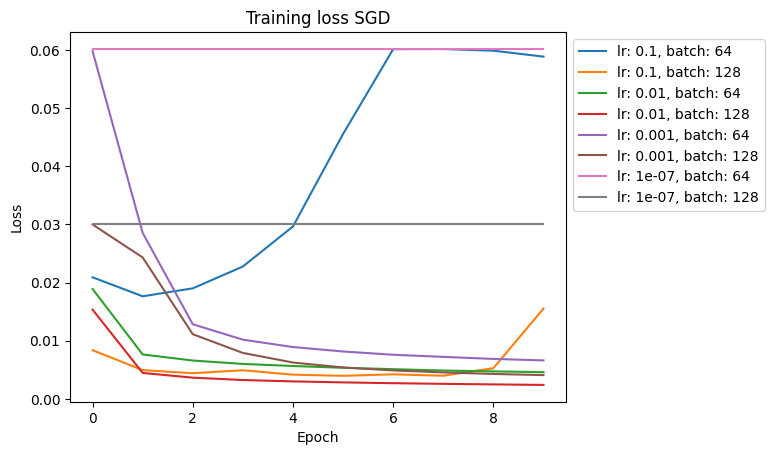

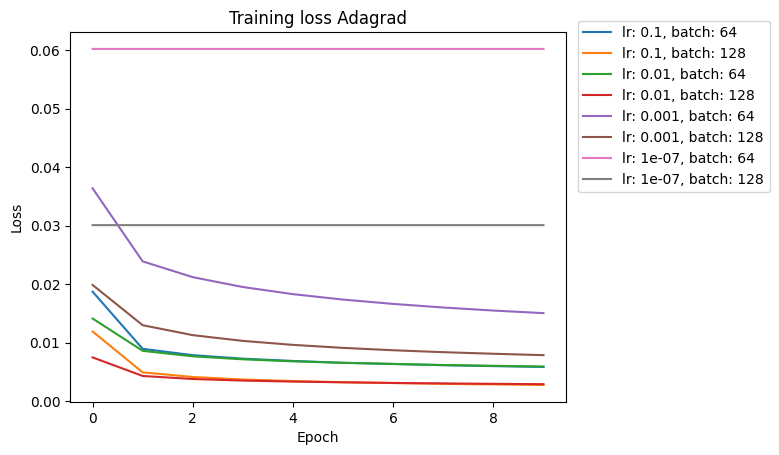

In [21]:
# SGD loss
for key in loss_hist:
    if key[1] == "SGD":
        plt.title(f"Training loss SGD")
        plt.plot(loss_hist[key], label=f"lr: {key[0]}, batch: {key[2]}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Adagrad loss
for key in loss_hist:
    if key[1] == "Adagrad":
        plt.title(f"Training loss Adagrad")
        plt.plot(loss_hist[key], label=f"lr: {key[0]}, batch: {key[2]}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.01, 1.05))
plt.show()

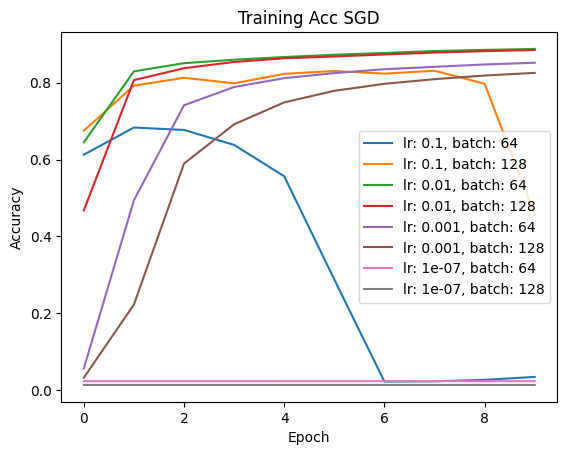

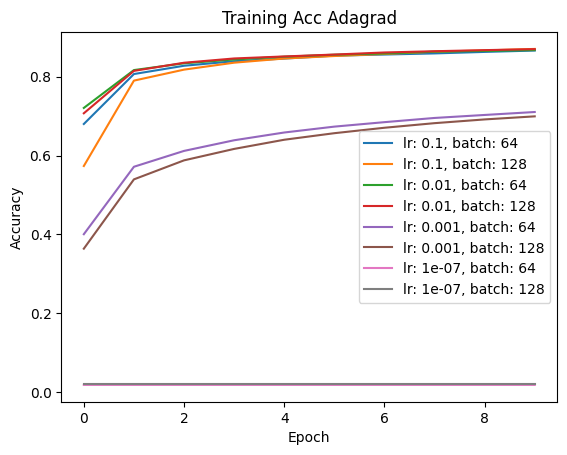

In [22]:
for key in acc_training_hist:
    if key[1] == "SGD":
        plt.title(f"Training Acc SGD")
        plt.plot(acc_training_hist[key], label=f"lr: {key[0]}, batch: {key[2]}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
plt.legend()
plt.show()

for key in acc_training_hist:
    if key[1] == "Adagrad":
        plt.title(f"Training Acc Adagrad")
        plt.plot(acc_training_hist[key], label=f"lr: {key[0]}, batch: {key[2]}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
plt.legend()
plt.show()

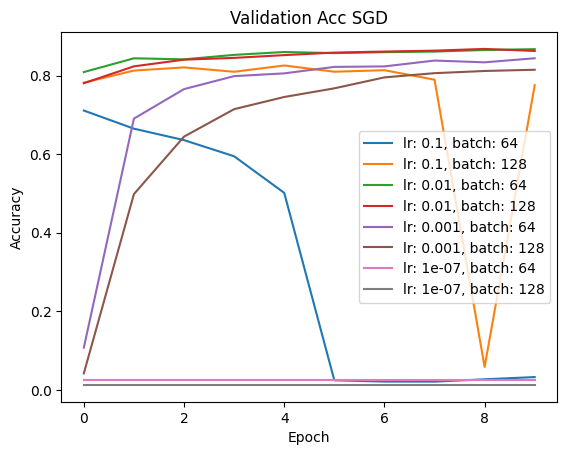

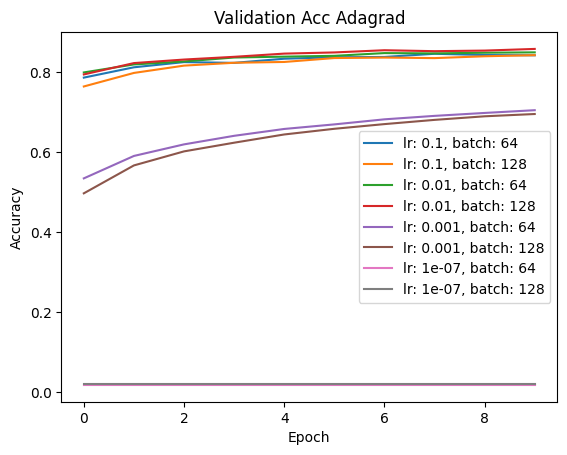

In [23]:
for key in acc_validation_hist:
    if key[1] == "SGD":
        plt.title(f"Validation Acc SGD")
        plt.plot(acc_validation_hist[key], label=f"lr: {key[0]}, batch: {key[2]}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
plt.legend()
plt.show()

for key in acc_validation_hist:
    if key[1] == "Adagrad":
        plt.title(f"Validation Acc Adagrad")
        plt.plot(acc_validation_hist[key], label=f"lr: {key[0]}, batch: {key[2]}")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
plt.legend()
plt.show()

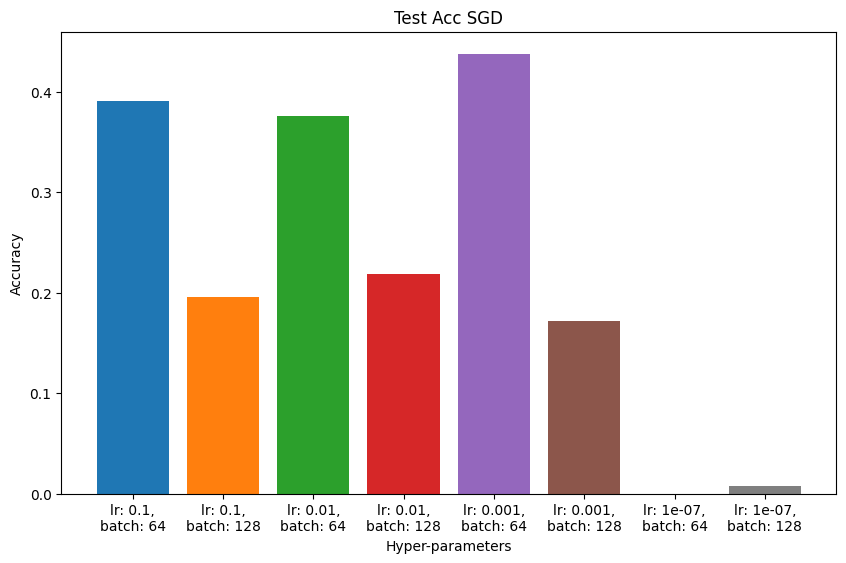

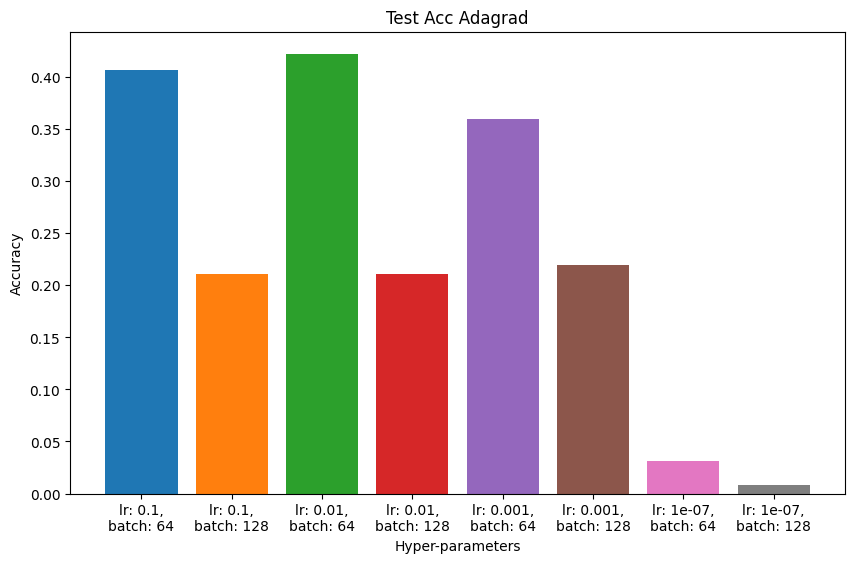

In [35]:
# test accuracy
plt.figure(figsize=(10,6))
for key in acc_test_hist:
    if key[1] == "SGD":
        score = float(acc_test_hist[key])
        # print(score)
        plt.bar(f"lr: {key[0]},\nbatch: {key[2]}", score)
        plt.title("Test Acc SGD")
        plt.xlabel("Hyper-parameters")
        plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(10,6))
for key in acc_test_hist:
    if key[1] == "Adagrad":
        score = float(acc_test_hist[key])
        # print(score)
        plt.bar(f"lr: {key[0]},\nbatch: {key[2]}", score)
        plt.title("Test Acc Adagrad")
        plt.xlabel("Hyper-parameters")
        plt.ylabel("Accuracy")
plt.show()